# Header

In [1]:
from utils import *
from plot import *
from calcCNV import *
from calcNMF import * 

/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [9]:
cell_cycle_genes = [x.strip() for x in open('../data/CellCycle/regev_lab_cell_cycle_genes.txt')]

In [10]:
# Prep files
chr_pos = pd.read_csv('../data/hg38_chromPos.csv', index_col=0)
gene_pos = pd.read_csv('../data/CNV/geneinfo.csv')

# Integrated CNAs among datasets

## Broad MCF7

In [2]:
metaDict = {'SRR10018059': 'MCF7-Parental-1',
 'SRR10018060': 'MCF7-Parental-2',
 'SRR10018061': 'MCF7-SC-WT3',
 'SRR10018062': 'MCF7-SC-WT3',
 'SRR10018063': 'MCF7-SC-WT4',
 'SRR10018064': 'MCF7-SC-WT4',
 'SRR10018065': 'MCF7-SC-WT5',
 'SRR10018066': 'MCF7-SC-WT5',
 'SRR10018067': 'MCF7-L-1',
 'SRR10018068': 'MCF7-L-2',
 'SRR10018069': 'MCF7-clone9-May-1',
 'SRR10018070': 'MCF7-clone9-May-2',
 'SRR10018071': 'MCF7-clone9-Nov-1',
 'SRR10018072': 'MCF7-clone9-Nov-2',
 'SRR10018149': 'MCF7-AA-t0',
 'SRR10018150': 'MCF7-AA-t12',
 'SRR10018151': 'MCF7-AA-t48',
 'SRR10018152': 'MCF7-AA-t96'}

In [6]:
for n, cell in enumerate(metaDict.keys()):

    adata_raw = sc.read('../data/BroadMCF7/adata/%s_ref_raw.h5ad'%cell)  
    adata_raw.var_names_make_unique()

    scv.pp.filter_genes(adata_raw, min_cells=2) 
    scv.pp.normalize_per_cell(adata_raw, layers=['spliced', 'unspliced']) # 3 layers all been normalized by / cts
    scv.pp.log1p(adata_raw) # only adata_raw.X is log1p (loge(x+1))

    tmp_adata = anndata.AnnData(adata_raw.X) 
    tmp_adata.obs.index = ['%s:%s'%(cell, x.strip('-1')) for x in adata_raw.obs.index]
    tmp_adata.var.index = adata_raw.var.index
    adata = tmp_adata if n==0 else adata.concatenate(tmp_adata)
    

Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.
Normalized count data: X.


In [7]:
adata.write('../data/BroadMCF7/logNormCts_Broad.h5ad')

## Merge datasets

In [8]:
Broad = sc.read('../data/BroadMCF7/logNormCts_Broad.h5ad')

In [15]:
AL1 = sc.read('../data/scVelo/AL1_ref_raw.h5ad')
AL1_fi = sc.read('../data/scVelo/AL1.h5ad')
mcf7 = pickle.load(open('../data/CNV/MCF7_RM.hugo.rawcounts.pkl','rb'))
t47d = pickle.load(open('../data/CNV/T47D.hugo.rawcounts.pkl','rb'))

In [16]:
goi = [g for g in AL1.var.index if g in mcf7.index and g in t47d.index and g in Broad.var.index]

AL1 = AL1[:,goi]
idx = list(AL1.obs.index)
CellTypes = AL1_fi.obs['CellType'].values
AL1.obs.index = [idx[i].replace('AL1', 'AL1_%s'%CellTypes[i]) for i in range(AL1.shape[0])]

Broad = Broad[:, goi]
mcf7 = mcf7.loc[goi,:]
t47d = t47d.loc[goi,:]
 
print('%d genes in common of the 6 lists'%(len(goi)))

15189 genes in common of the 6 lists


In [17]:
chr_pos = pd.read_csv('../data/CNV/hg38_chromPos.csv', index_col=0)
gene_pos = pd.read_csv('../data/CNV/geneinfo.csv')

In [18]:
adata_mg = AL1.concatenate(Broad)
Cells = np.array(adata_mg.obs.index) 
Genes = np.array(adata_mg.var.index)

X = np.array(adata_mg.X.todense()).T # genes X cell
X = np.hstack((X, mcf7.values, t47d.values)) # add ref as the last col of X
E = np.log2(1+1e4*X/np.sum(X, axis=0))

layers are inconsistent - only layers that are shared among all AnnData objects are included.


In [19]:
win = 100 
min_genes_per_arm = 100
chrs = []
n = -1  

for arm in chr_pos.index:

    genes = gene_pos[gene_pos['arm']==arm].sort_values(by=['txStart'])['symbol'].values # ordered
    genes_s = [g for g in genes if g in Genes]

    if len(genes_s) < min_genes_per_arm:
        print('Low cov: {}'.format(arm))
        
    if len(genes_s) > min_genes_per_arm:
        n += 1        
        X_sel = E[[np.where(Genes==g)[0][0] for g in genes_s],:] # pre-calc to speed up
        MvAvg = np.apply_along_axis(lambda x:np.convolve(x, np.ones((win,))/win, mode='valid'), 0, X_sel) 
        chrs.extend([arm] * len(MvAvg))
        
        if n == 0:
            cnv = MvAvg
        elif n > 0:
            cnv = np.vstack((cnv, MvAvg))

cnv_df = pd.DataFrame(cnv)
cnv_df.index = chrs  # chr x cell

Low cov: 13p
Low cov: 14p
Low cov: 15p
Low cov: 18p
Low cov: 21p
Low cov: 22p
Low cov: Yp
Low cov: Yq


In [24]:
cnv_df.columns = list(adata_mg.obs.index) + list(['AdaptMCF7:%s'%x for x in mcf7.columns]) + list(['AdaptT47D:%s'%x for x in t47d.columns]) 

cnv_adata = anndata.AnnData(cnv_df.T) # cell x chr                            
cnv_adata.write("../data/CNV/logNormCts_100winCNV.h5ad")

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [25]:
cnv_adata = sc.read("../data/CNV/logNormCts_100winCNV.h5ad")
cnv_adata.shape 
cnv_df = pd.DataFrame(cnv_adata.X, index=cnv_adata.obs.index, columns=cnv_adata.var.index) # 

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [26]:
CellTypes = [x.split(':')[0] for x in cnv_adata.obs.index]
cnv_adata.obs['CellType'] = CellTypes

TypeDict = dict(Counter(CellTypes)) 
TypeDict

{'AL1_MM134': 439,
 'AL1_T47D KO': 491,
 'AL1_T47D WT': 509,
 'AL1_MCF7': 977,
 'AL1_SUM44': 314,
 'AL1_HEK293': 881,
 'AL1_MCF10A': 491,
 'AL1_BCK4': 512,
 'SRR10018059': 2946,
 'SRR10018060': 2948,
 'SRR10018061': 3029,
 'SRR10018062': 3024,
 'SRR10018063': 3700,
 'SRR10018064': 3705,
 'SRR10018065': 4791,
 'SRR10018066': 4791,
 'SRR10018067': 3396,
 'SRR10018068': 3398,
 'SRR10018069': 4178,
 'SRR10018070': 4189,
 'SRR10018071': 4024,
 'SRR10018072': 4037,
 'SRR10018149': 1560,
 'SRR10018150': 2625,
 'SRR10018151': 1797,
 'SRR10018152': 1193,
 'AdaptMCF7': 1215,
 'AdaptT47D': 500}

In [29]:
ref = cnv_adata[cnv_adata.obs['CellType']=='AL1_MCF10A'].X 
ref_vec = np.mean(ref, axis=0)

def calcResidue(x):
    
    from sklearn.linear_model import LinearRegression
    X = x.reshape(x.shape[0],1)
    y=ref_vec
    Y = y.reshape(y.shape[0],1)
    
    reg = LinearRegression().fit(X, Y)
    residues = Y - reg.predict(X)
    
    return list(residues.flatten())


Residues = np.apply_along_axis(calcResidue, 1, cnv_df.values)
Residues.shape 

(65660, 11148)

In [30]:
Residues_df = pd.DataFrame(Residues, index=cnv_adata.obs.index, columns=cnv_adata.var.index) # gene x cell

In [31]:
Residues_adata = anndata.AnnData(Residues_df)
Residues_adata.write("../data/CNV/logNormCts_100winCNV_Residues.h5ad")

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Plot 100 win residuals

In [32]:
chr_pos = pd.read_csv('../data/CNV/hg38_chromPos.csv', index_col=0)
Chroms = np.array([chrom for chrom in chr_pos.index if chrom in Residues_adata.var.index])
Chroms

array(['1p', '1q', '2p', '2q', '3p', '3q', '4p', '4q', '5p', '5q', '6p',
       '6q', '7p', '7q', '8p', '8q', '9p', '9q', '10p', '10q', '11p',
       '11q', '12p', '12q', '13q', '14q', '15q', '16p', '16q', '17p',
       '17q', '18q', '19p', '19q', '20p', '20q', '21q', '22q', 'Xp', 'Xq'],
      dtype='<U3')

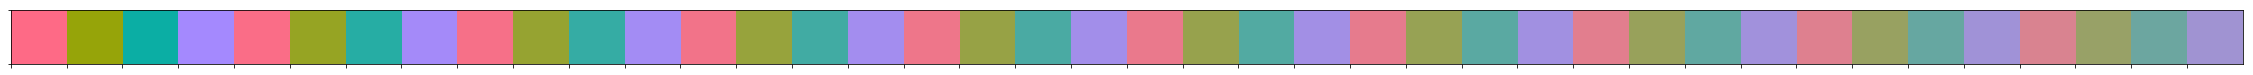

In [33]:
c5 = sns.husl_palette(n_colors=4, s=1)
clist = []

for i in range(len(Chroms)):
    p = i % 4
    q = i // 4
    clist.append(sns.husl_palette(n_colors=4, s=1-0.05*q)[p])
    
len(clist)==len(Chroms)

chroms_colors = clist
sns.palplot(chroms_colors)

In [34]:
CellTypes = [x.split(':')[0] for x in Residues_adata.obs.index]
TypeDict = dict(Counter(CellTypes)) 
TypeDict

{'AL1_MM134': 439,
 'AL1_T47D KO': 491,
 'AL1_T47D WT': 509,
 'AL1_MCF7': 977,
 'AL1_SUM44': 314,
 'AL1_HEK293': 881,
 'AL1_MCF10A': 491,
 'AL1_BCK4': 512,
 'SRR10018059': 2946,
 'SRR10018060': 2948,
 'SRR10018061': 3029,
 'SRR10018062': 3024,
 'SRR10018063': 3700,
 'SRR10018064': 3705,
 'SRR10018065': 4791,
 'SRR10018066': 4791,
 'SRR10018067': 3396,
 'SRR10018068': 3398,
 'SRR10018069': 4178,
 'SRR10018070': 4189,
 'SRR10018071': 4024,
 'SRR10018072': 4037,
 'SRR10018149': 1560,
 'SRR10018150': 2625,
 'SRR10018151': 1797,
 'SRR10018152': 1193,
 'AdaptMCF7': 1215,
 'AdaptT47D': 500}

In [35]:
TypeDict.keys()

dict_keys(['AL1_MM134', 'AL1_T47D KO', 'AL1_T47D WT', 'AL1_MCF7', 'AL1_SUM44', 'AL1_HEK293', 'AL1_MCF10A', 'AL1_BCK4', 'SRR10018059', 'SRR10018060', 'SRR10018061', 'SRR10018062', 'SRR10018063', 'SRR10018064', 'SRR10018065', 'SRR10018066', 'SRR10018067', 'SRR10018068', 'SRR10018069', 'SRR10018070', 'SRR10018071', 'SRR10018072', 'SRR10018149', 'SRR10018150', 'SRR10018151', 'SRR10018152', 'AdaptMCF7', 'AdaptT47D'])

In [36]:
from numpy.random import randint

Barcodes = Residues_adata.obs.index
X = Residues_adata.X
Cells = ['AL1_MCF7','AL1_T47D WT','AL1_T47D KO','AL1_MM134','AL1_SUM44','AL1_BCK4','AL1_MCF10A','AL1_HEK293',
        'AdaptMCF7','AdaptT47D',
        'SRR10018061', 'SRR10018063','SRR10018065']

n = -1
sampling_size = 100

for k in Cells:
    n += 1
    bcs = np.array([x.startswith(k) for x in Barcodes])
    tmp = X[bcs,:][randint(0, high=TypeDict[k], size=sampling_size),:]

    if n==0:
        df_p = tmp
    else:
        df_p = np.vstack([df_p, tmp])
    print(k, df_p.shape)

df_p = pd.DataFrame(df_p, index=['{}:{}'.format(x,i) for x in Cells for i in range(sampling_size)], columns=Residues_adata.var.index)
    # df_p = Residues_df.loc[all_sel, :]

AL1_MCF7 (100, 11148)
AL1_T47D WT (200, 11148)
AL1_T47D KO (300, 11148)
AL1_MM134 (400, 11148)
AL1_SUM44 (500, 11148)
AL1_BCK4 (600, 11148)
AL1_MCF10A (700, 11148)
AL1_HEK293 (800, 11148)
AdaptMCF7 (900, 11148)
AdaptT47D (1000, 11148)
SRR10018061 (1100, 11148)
SRR10018063 (1200, 11148)
SRR10018065 (1300, 11148)


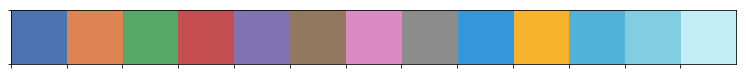

In [37]:
# Cells = ['AL1_MCF7','AL1_T47D WT','AL1_T47D KO','AL1_MM134','AL1_SUM44','AL1_BCK4','AL1_MCF10A','AL1_HEK293',
#         'AdaptMCF7','AdaptT47D',
#         'SRR10018061', 'SRR10018063','SRR10018065']

cell_pallete = [x+(1,) for x in sns.color_palette("deep")[:8]] + [np.array(x)/256 for x in [[52, 152, 219],[249, 180, 45],   [82, 179, 217],[129, 207, 224],[197, 239, 247]]] 
sns.palplot(cell_pallete)

In [38]:
print(df_p.shape)
df_p.head(3)

(1300, 11148)


index,1p,1p,1p,1p,1p,1p,1p,1p,1p,1p,...,Xq,Xq,Xq,Xq,Xq,Xq,Xq,Xq,Xq,Xq
AL1_MCF7:0,0.006706,0.007513,0.007581,0.007503,0.005803,0.006865,0.006333,0.010902,0.012146,0.023221,...,-0.090866,-0.092835,-0.094151,-0.094799,-0.091533,-0.093642,-0.093528,-0.094522,-0.095559,-0.096606
AL1_MCF7:1,-0.008136,-0.007329,-0.007260,-0.004198,-0.004207,-0.005761,-0.006294,-0.007140,-0.007587,0.004345,...,-0.094364,-0.092573,-0.087338,-0.087986,-0.089235,-0.095482,-0.097828,-0.098822,-0.097789,-0.093627
AL1_MCF7:2,-0.066184,-0.065377,-0.065308,-0.062246,-0.062255,-0.056784,-0.057316,-0.054595,-0.055043,-0.045169,...,-0.101216,-0.101067,-0.106815,-0.107464,-0.103628,-0.101328,-0.098756,-0.096183,-0.096792,-0.097840


In [45]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True)
plt.style.use(['NaturePub']) 

In [46]:
chroms_colors = clist
col_colors = [clist[np.where(Chroms==c)[0][0]] for c in df_p.columns]
row_colors = [ele for ele in cell_pallete for i in range(sampling_size)] 


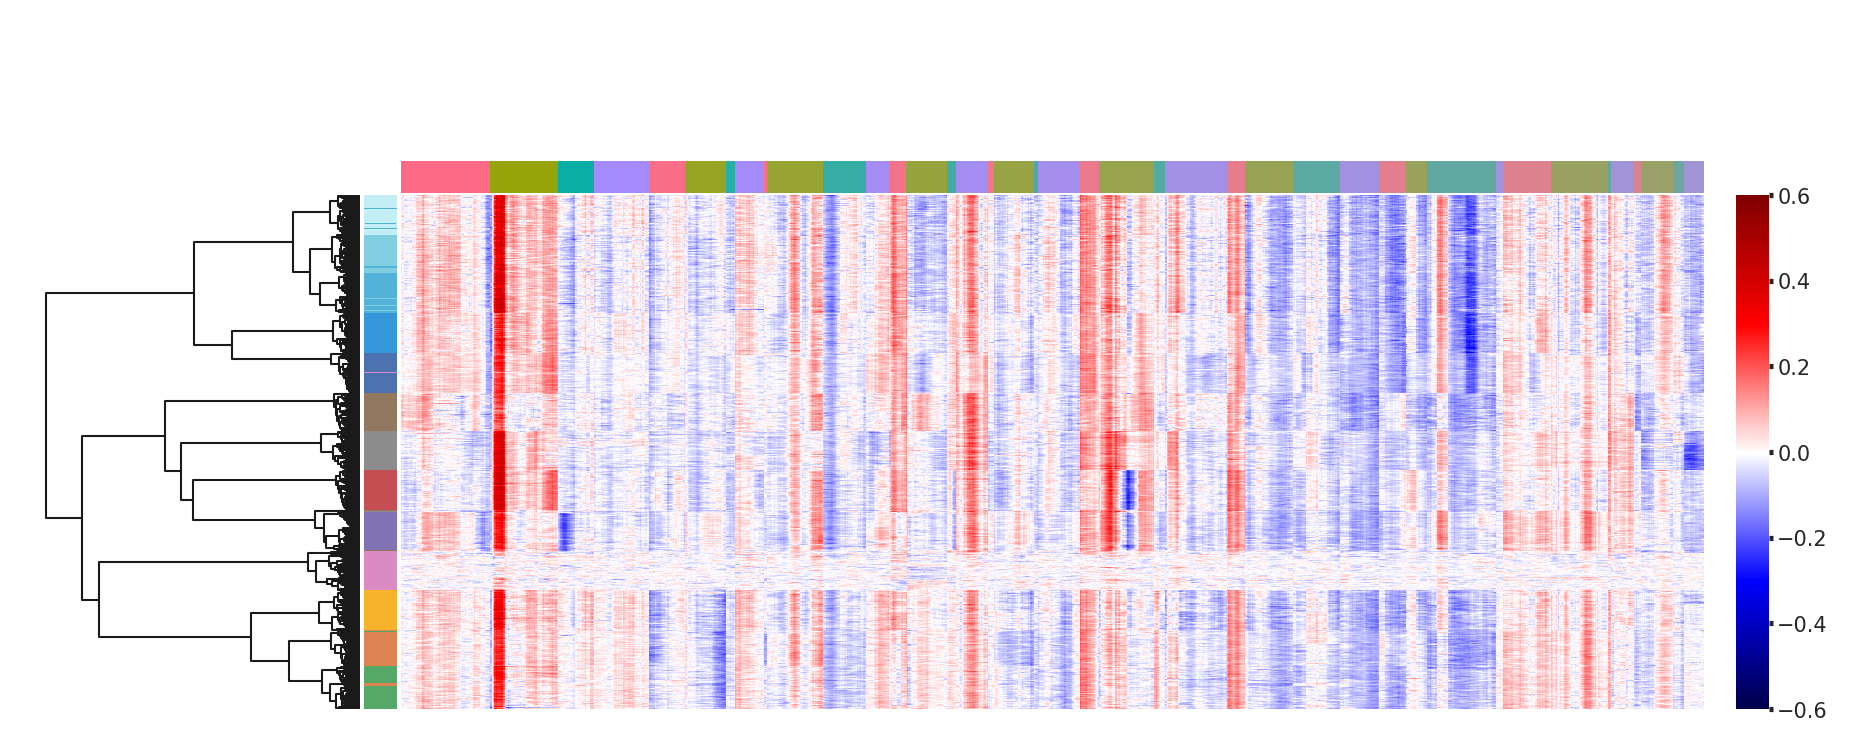

In [47]:
g = sns.clustermap(df_p, method='ward', metric='euclidean', col_cluster=False,
                   col_colors=[col_colors], row_colors=[row_colors], cmap='seismic', vmin=-0.6, vmax=0.6,
                   width_colors_ratio=0.02, height_colors_ratio=0.05,
                   figsize=(7.2,3))
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')

xticklabels = df_p.columns
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xticklabels('')
g.ax_heatmap.set_xlabel('')

cbar = g.cax
x0,y0,x1,y1 = np.array(g.ax_heatmap.get_position()).flatten()
cbar.set_position([x1+0.015, y0, 0.015, y1-y0])

In [48]:
g.savefig('../Figure/Fig2/CNV_Heatmap_3datasets.png', dpi=300, bbox_inches='tight') 